In [21]:
from classes.Ann import Ann
from classes.DataLoader import DataLoader
from classes.Simulation import Simulation
from classes.Simulation_extension import Simulation_extension

from utils.init_functions import *

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

In [22]:
data = pd.read_csv("data/dataset.csv", index_col=0)
df_trv = data.rolling(5).std()
df_trv.index = pd.to_datetime(df_trv.index)
df_trv = df_trv.iloc[4:]
df = df_trv["S&P500"].dropna() 
mi = df.min()
ma = df.max()
df = (df - mi)/(ma-mi)

df = df["2000":"2014"]

In [23]:
pivot_index_training_1 = round(df.shape[0] * 0.25)
pivot_index_training_2 = round(df.shape[0] * 0.75)

df_train_1 = df.iloc[:pivot_index_training_1]

In [24]:
ite_train_1 = DataLoader(df=df_train_1, Y=df_train_1.values, window_size=30, batch_size=df_train_1.shape[0])
for batch in ite_train_1: # Only one batch there
    X_train_1,y_train_1 = batch

rf_rgs = RandomForestRegressor()  # RandomForestRegressor(max_features = 10, min_samples_split = 24)   
rf_rgs.fit(X_train_1,y_train_1)

sv_rgs = SVR(kernel='rbf')
sv_rgs.fit(X_train_1,y_train_1)

gb_rgs = GradientBoostingRegressor()  # GradientBoostingRegressor(learning_rate = 0.003, n_estimators=1479)
gb_rgs.fit(X_train_1,y_train_1)

GradientBoostingRegressor()

In [25]:
df_ann = df.iloc[pivot_index_training_1:]
ite = DataLoader(df=df_ann, Y=df_ann.values, window_size=30, batch_size=df_ann.shape[0])

for batch in ite: # Only one batch there
    X,y = batch

df_train_ann = pd.DataFrame(X, index=df_ann.index[30:])
df_train_ann["rf"] = rf_rgs.predict(X)
df_train_ann["sv"] = sv_rgs.predict(X)
df_train_ann["gb"] = gb_rgs.predict(X)

kwargs = dict(
    learning_rate = 1e-3,
    batch_size = df_train_ann.shape[0],
    num_epochs = 10000, 
    window_size = 30,
    weight_decay = 0,
    tab = df_train_ann.values,
    y = y,
)

init_functions = [
    "random_normal",
    "random_uniform",
    "truncated_normal",
    "zeros",
    "ones",
    "glorot_normal",
    "glorot_uniform",
    "identity",
    "orthogonal",
    "constant_",
    "variance_scaling",
]

In [9]:
simu = {func:Simulation(**kwargs) for func in init_functions}
for func in simu:
    simu[func].make_dataloaders(pivot_index=pivot_index_training_2-pivot_index_training_1)
    simu[func].Ann.init_weights(eval(func))
    simu[func].train(verbose=1)
    simu[func].Ann.save("models/torch/{}".format(func))
    print("Simulation {} trained.".format(func))

Train loss: 0.0450 | Test loss: 0.0577: 100%|██████████| 10000/10000 [00:35<00:00, 279.34it/s]


Simulation random_normal trained.


Train loss: 0.0406 | Test loss: 0.0618: 100%|██████████| 10000/10000 [00:36<00:00, 274.66it/s]


Simulation random_uniform trained.


Train loss: 0.0483 | Test loss: 0.0556: 100%|██████████| 10000/10000 [00:34<00:00, 287.31it/s]


Simulation truncated_normal trained.


Train loss: 0.0563 | Test loss: 0.0548: 100%|██████████| 10000/10000 [00:38<00:00, 262.92it/s]


Simulation zeros trained.


Train loss: 0.3601 | Test loss: 0.2376: 100%|██████████| 10000/10000 [00:41<00:00, 243.69it/s]     


Simulation ones trained.


Train loss: 0.0591 | Test loss: 0.0541: 100%|██████████| 10000/10000 [00:39<00:00, 256.36it/s] 


Simulation glorot_normal trained.


Train loss: 0.0495 | Test loss: 0.0557: 100%|██████████| 10000/10000 [00:37<00:00, 269.73it/s]


Simulation glorot_uniform trained.


Train loss: 0.0565 | Test loss: 0.0534: 100%|██████████| 10000/10000 [00:36<00:00, 271.52it/s] 


Simulation identity trained.


Train loss: 0.0501 | Test loss: 0.0561: 100%|██████████| 10000/10000 [00:42<00:00, 237.95it/s]


Simulation orthogonal trained.


Train loss: 0.0563 | Test loss: 0.0545: 100%|██████████| 10000/10000 [00:44<00:00, 224.47it/s]


Simulation constant_ trained.


Train loss: 0.0412 | Test loss: 0.0632: 100%|██████████| 10000/10000 [00:43<00:00, 231.41it/s]


Simulation variance_scaling trained.


<AxesSubplot:title={'center':'random_normal train set, RMSE : 0.03278'}, ylabel='Scaled volatility'>

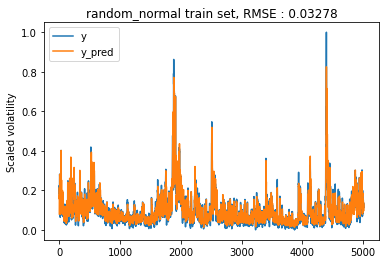

In [29]:
import torch

data = pd.read_csv("data/dataset.csv", index_col=0)
df_trv = data.rolling(5).std()
df_trv.index = pd.to_datetime(df_trv.index)
df_trv = df_trv.iloc[4:]
df = df_trv["S&P500"].dropna() 
mi = df.min()
ma = df.max()
df = (df - mi)/(ma-mi)

ite = DataLoader(df=df, Y=df.values, window_size=30, batch_size=df.shape[0])

for batch in ite: # Only one batch there
    X,y = batch


aux = pd.DataFrame(X)
aux["rf"] = rf_rgs.predict(X)
aux["sv"] = sv_rgs.predict(X)
aux["gb"] = gb_rgs.predict(X)


df_train = pd.DataFrame(y, columns=["y"])
df_train["y_pred"] = simu_ext[init_functions[0]].Ann_extension(torch.Tensor(aux.values)).detach().numpy()
df_train.plot(
    title="{} train set, RMSE : {:.5f}".format(func,mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")

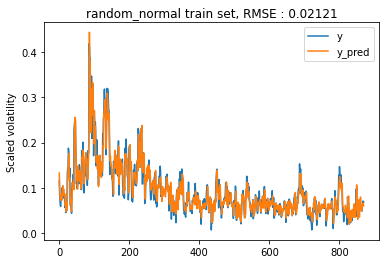

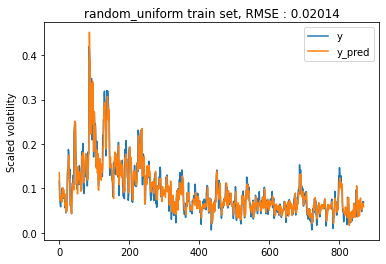

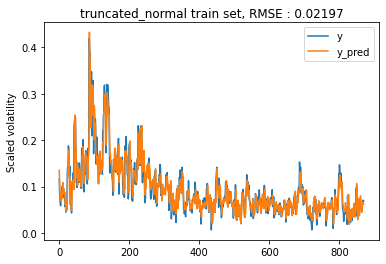

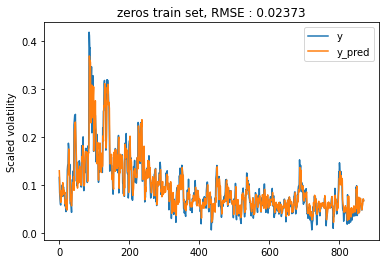

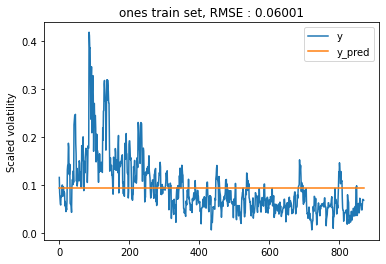

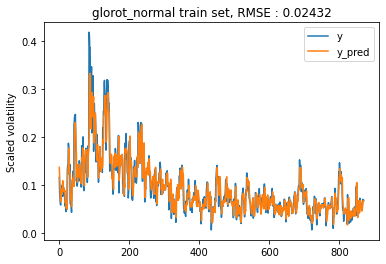

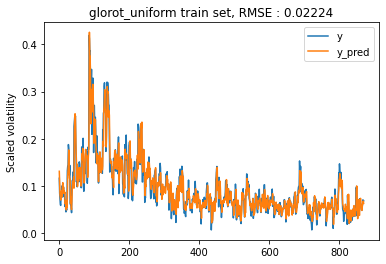

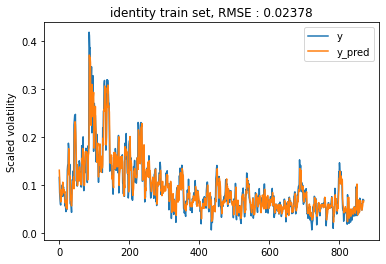

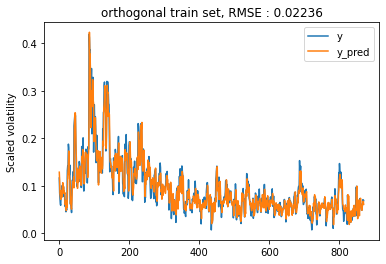

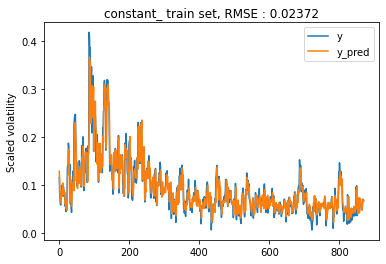

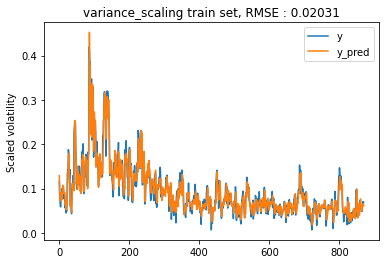

In [13]:
for batch in simu[init_functions[0]].dataloaders["train"]():
    x,y = batch

for func in simu:
    df_train = pd.DataFrame(y, columns=["y"])
    df_train["y_pred"] = simu[func].Ann(x).detach().numpy()
    df_train.plot(
        title="{} train set, RMSE : {:.5f}".format(func,mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
        ylabel="Scaled volatility")

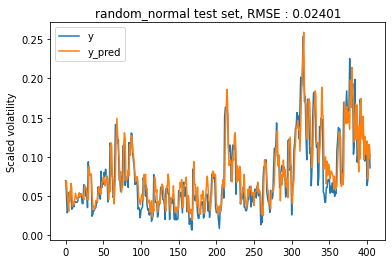

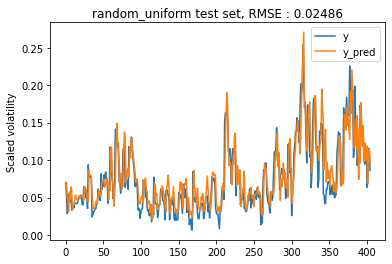

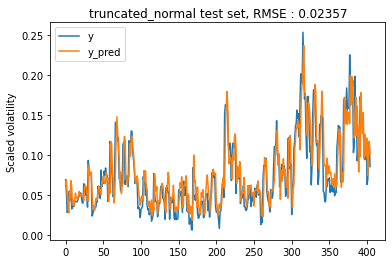

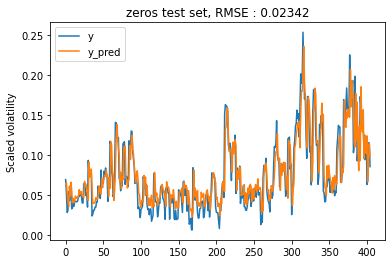

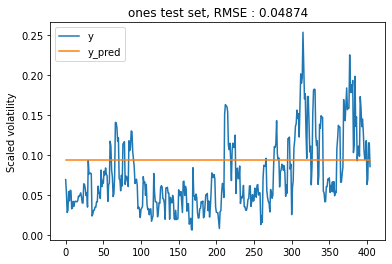

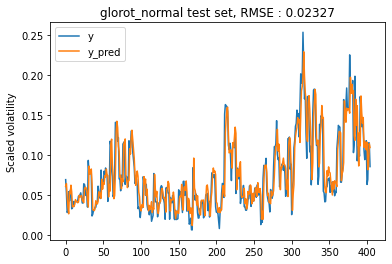

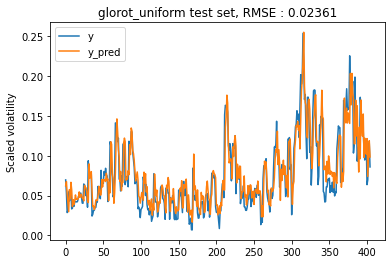

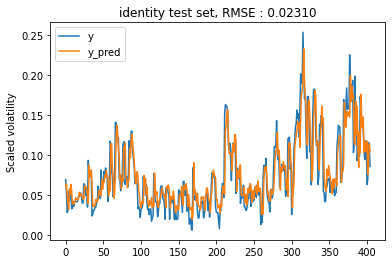

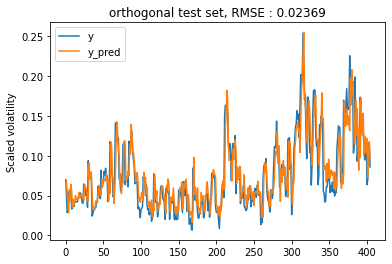

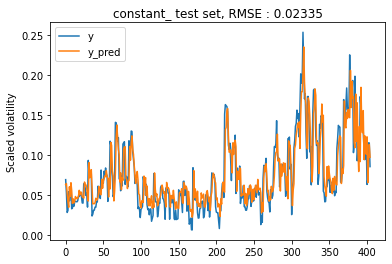

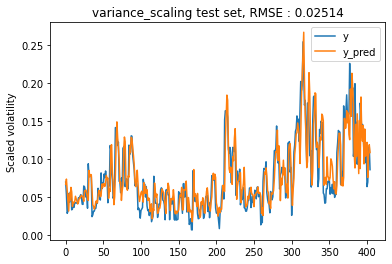

In [14]:
for batch in simu[init_functions[0]].dataloaders["test"]():
    x,y = batch

for func in simu:
    df_train = pd.DataFrame(y, columns=["y"])
    df_train["y_pred"] = simu[func].Ann(x).detach().numpy()
    df_train.plot(
        title="{} test set, RMSE : {:.5f}".format(func,mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
        ylabel="Scaled volatility")

In [33]:
import torch.nn as nn
import torch

a = nn.LSTM(11,2)
b = nn.LSTM(2,5)
b(a(torch.Tensor([[i for i in range(11)]]))[0])

(tensor([[-0.0970, -0.0618,  0.0290, -0.0550, -0.0327]],
        grad_fn=<SqueezeBackward1>),
 (tensor([[-0.0970, -0.0618,  0.0290, -0.0550, -0.0327]],
         grad_fn=<SqueezeBackward1>),
  tensor([[-0.2148, -0.0977,  0.0604, -0.0855, -0.0669]],
         grad_fn=<SqueezeBackward1>)))

In [ ]:
kwargs = dict(
    learning_rate = 0.01,
    batch_size = df_train_ann.shape[0],
    num_epochs = 1000, 
    window_size = 30,
    weight_decay = 0,
    tab = df_train_ann.values,
    y = y,
)

simu_ext = {func:Simulation_extension(**kwargs) for func in init_functions}
for func in simu_ext:
    simu_ext[func].make_dataloaders(pivot_index=pivot_index_training_2-pivot_index_training_1)
    simu_ext[func].Ann_extension.init_weights(eval(func))
    simu_ext[func].train(verbose=1)
    simu_ext[func].Ann.save("models/torch/extension/{}".format(func))
    print("Simulation {} trained.".format(func))

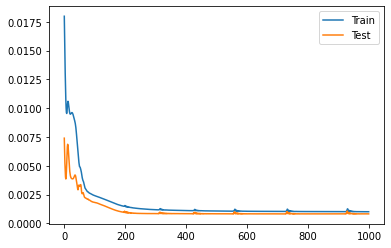

In [30]:
simu_ext["random_normal"].plot_loss()

In [ ]:
for batch in simu_ext[init_functions[0]].dataloaders["test"]():
    x,y = batch

df_train = pd.DataFrame(y, columns=["y"])
df_train["y_pred"] = simu_ext[init_functions[0]].Ann_extension(x).detach().numpy()
df_train.plot(
    title="{} train set, RMSE : {:.5f}".format(func,mean_squared_error(df_train["y"], df_train["y_pred"], squared=False)),
    ylabel="Scaled volatility")